The following code implements the authority shift clustering method presented in [1]:

[1] Cho and MuLee. 2010. Authority-shift clustering: Hierarchical clustering by authority seeking on graphs. https://ieeexplore.ieee.org/document/5540081

The utility function computeNormalizedAffinity determines the row stochastic matrix from a 2D point cloud useful to represent the adjacency between points (nodes).

In [1]:
import math
import numpy as np
import scipy
from scipy import sparse
from scipy.spatial.distance import pdist
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
################## computeNormalizedAffinity ##################

def computeNormalizedAffinity(data, scale = float('nan'), order =float('nan')):
    # input: data point cloud vector
    # output: Prw column stochastic matrix of point cloud as a graph linked by euclidean distance edges
    
    #This function computes the transition matrix corresponding to
    #a graph model of the 2D data distribution. The graph is a undirected
    #weighted graph with weigths depending on the eucledian distance
    #between points (nodes).
    #Symmetric square matrix of euclidean distances between points
    distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(data))

    if math.isnan(scale):
        scale = 0.05*distances.max()
    if math.isnan(order):
        order = 2;

    W = np.exp(-(distances/scale)**order)
   
    nPoints = W.shape[0]
    # column-stochastic matrix
    Prw = W
    for itr in range(0, nPoints):
        Prw[itr,itr] = 0
    
    #normalize by column to obtain a column stochastic transition matrix
    D = np.diag(1 / Prw.sum(axis=0))
    Prw =  np.matmul(Prw, D)
    
    return Prw


The function computeInitialPPRs returns the Personalized PageRank Matrix: i-th column is the personalized PageRank for the i-th node.

In [3]:
################## computeInitialPPRs ##################
    
def computeInitialPPRs(Prw, c):
    # input: Prw column stochastic matrix representing a graph
    # input: c damping factor
    # output: W_PPR Personalized PageRank Matrix
    
    #This function computes the Perzonalized pageranks matrix
    #given the column stochastic transition matrix Prw
    #and the damping factor c.
    nSize = Prw.shape[0]

    # make personalization matrix
    W_PPR = np.linalg.inv( (scipy.sparse.eye(nSize) - c * Prw) ) * (1 - c) # nSize by nSeed
    W_PPR = W_PPR - scipy.sparse.eye(nSize) * (1-c) # bias subtraction
    
    #normalize by column
    W_PPR = np.array(W_PPR)
    normM = np.diag(1 / W_PPR.sum(axis=0))
    W_PPR = np.matmul(W_PPR, normM)

    return W_PPR

In [4]:
################## computeInitialPPRsFast ##################
    
def push(Prw, c, u, v):
    #auxiliary functtion called by computeInitialPPRsFast
    nSize = Prw.shape[0]
    k = np.argmax(v)
    u_update = np.copy(u);
    u_update[k] += (1 - c) * v[k]
    v_update = np.copy(v)
    v_update[k] = 0.0
    v_update += (c * v[k]) * Prw[:,k].reshape(nSize)
    return u_update, v_update

################## computeInitialPPRsFast ##################
    
def computeInitialPPRsFast(Prw, c, epsilon):
    # input: Prw column stochastic matrix representing a graph
    # input: c damping factor
    # output: W_PPR Personalized PageRank Matrix
    
    #This function computes the approximated Perzonalized pageranks matrix
    #given the column stochastic transition matrix Prw
    #and the damping factor c.   nSize = Prw.shape[0]
    d = Prw.sum(axis=1)
    # make personalization matrix
    W_PPR = np.zeros((nSize,nSize))
    
    for i in range(nSize):
        u = np.zeros(nSize)
        v = np.zeros(nSize)
        v[i] = 1
        k = i
        # to be completed
        while v.max() >= epsilon * d[k]: 
            u, v = push(Prw, c, u, v)
            k = np.argmax(v)

        # insert approx pagerank in the pageranks' matrix
        #W_PPR[:,i] = u.reshape(nSize, 1) 
        W_PPR[:,i] = u

    W_PPR = W_PPR - scipy.sparse.eye(nSize) * (1-c) # bias subtraction
    W_PPR = np.array(W_PPR)
    
    # normalize each approximate pagerank in order its L1 norm is 1 
    normM = np.diag(1 / W_PPR.sum(axis=0))
    W_PPR = np.matmul(W_PPR, normM)
    
    
    return W_PPR

The findSink utility function determines the authorithy shift for each graph node.

In [5]:
################## findSink ##################

def findSink(shifted_idx):
    # Find sink for each node by traversals
    # input : shifted indexes 
    # ouput : sink indexes

    sinkIdx = [0 for i in range(shifted_idx.shape[0])]
    nNode = len(shifted_idx)

    # Traverse for each node
    for i in range(nNode):
        sinkIdx = findSinkRecur(i, shifted_idx, sinkIdx )
    
    return sinkIdx

def findSinkRecur( cur_idx, shifted_idx, sinkIdx ):
    if cur_idx == shifted_idx[cur_idx]: # if a sink
        sinkIdx[cur_idx] = cur_idx;
    else:
        if sinkIdx[shifted_idx[cur_idx]] == 0: # if not labelled, dive into recursion
            sinkIdx[cur_idx] = cur_idx                      # footmark for a cyclic sink
            sinkIdx = findSinkRecur(shifted_idx[cur_idx], shifted_idx, sinkIdx )
        sinkIdx[cur_idx] = sinkIdx[shifted_idx[cur_idx]]    # inherit the sink label

    return sinkIdx


The function authorityShiftPoint implements the authority shift clustering method

In [6]:
################## authorityShiftPoint ##################

def authorityShiftPoint(points, Prw, authorityshift_c, numClusters, fastEnable = False):
    # input: points data point cloud vector
    # input: Prw column stochastic matrix representing a graph
    # input: authorityshift_c damping factor
    # input: numClusters number of clusters in the point cloud
    # input: fastEnable bolean value to compute PPR using computeInitialPPRsFast or computeInitialPPRs
    # output: authIdx_all list of the authority of each node

    c = authorityshift_c
    iter_max = 10000

    if fastEnable:
        W_PPR_initial = computeInitialPPRsFast(Prw, c, 0.01)
    else:
        W_PPR_initial = computeInitialPPRs(Prw, c)

    nSize = points.shape[0]

    # initiaization for authority-shift
    W_PPR_reduced = W_PPR_initial              # initial PPRs for the current layer
    W_PPR_nOrder = W_PPR_initial               # nth order PPRs in the current layer

    # authIdx: indexes of seed nodes, initial seed list, each node is itself authority
    # szOfAuthIdx: num of elements sharing the same authority
    # authIdx_all : authority nodes of each elements 
    authIdx = list(range(nSize))                # current index set of authority nodes (super nodes)
    authIdx_all = list(range(nSize))            # current authority index for each initial node
    szOfAuthIdx = [1 for i in range(nSize)]     # member size for each super node
    nPPROrder = 1                               # PPR order for the current layer

    for kIter in range(0,iter_max):
        # authority-shifting: where is my authority node?
        shiftVal = np.amax(W_PPR_nOrder, axis = 0)
        elementIdx = np.argmax(W_PPR_nOrder, axis = 0)

        # find authority-sink for each node
        sink_elementIdx = findSink(elementIdx)
        final_authIdx = [authIdx[i] for i in sink_elementIdx]

        shifted_idx = []
        for i in range(0, len(final_authIdx)):
            if final_authIdx[i] != authIdx[i]:
                shifted_idx.append(i)

        new_seedList = sorted(list(set(final_authIdx)))

        # hierarchical approach 
        if len(shifted_idx) == 0:
            # PPR propagation for n-th order PPR
            W_PPR_nOrder = np.matmul(W_PPR_reduced, W_PPR_nOrder)
            nPPROrder = nPPROrder + 1
        else: # supernode aggregation and matrix reduction
            # edit authIdx_all
            for cIdx in shifted_idx:
                for i in range(len(authIdx_all)):
                    if authIdx_all[i] == authIdx[cIdx]:
                        authIdx_all[i] = final_authIdx[cIdx]

            # start updating W_PPR_reduced
            tmp_W_PPR_reduced = np.zeros((len(authIdx),len(new_seedList)))

            new_szOfAuthIdx = [0 for i in range(len(new_seedList))]

            # First, row-wise summation considering sizes of supernodes
            for jIter in range(len(new_seedList)):
                tmp_seedListIdx = []
                for i in range(0, len(final_authIdx)):
                    if final_authIdx[i] == new_seedList[jIter]:
                        tmp_seedListIdx.append(i)
                
                for i in tmp_seedListIdx:
                    new_szOfAuthIdx[jIter] = new_szOfAuthIdx[jIter] + szOfAuthIdx[i]
                
                # if more than one node has been shifted
                if len(tmp_seedListIdx) > 1:
                    tmp_szOfAuthIdx = np.array(szOfAuthIdx)
                    tmp_Norm = np.diag(tmp_szOfAuthIdx[tmp_seedListIdx]) / new_szOfAuthIdx[jIter]
                    
                    tmp_W_PPR_reduced[:,jIter] = np.sum( np.matmul(W_PPR_reduced[:,tmp_seedListIdx], tmp_Norm) , 1)
                else:
                    tmp_W_PPR_reduced[:,jIter] = W_PPR_reduced[:,tmp_seedListIdx[0]]

            # Second, column-wise summation, just sum!
            new_W_PPR_reduced = np.zeros((len(new_seedList),len(new_seedList)))
            for jIter in range(len(new_seedList)):
                tmp_seedListIdx = []
                for i in range(0, len(final_authIdx)):
                    if final_authIdx[i] == new_seedList[jIter]:
                        tmp_seedListIdx.append(i)
                new_W_PPR_reduced[jIter,:] = np.sum(tmp_W_PPR_reduced[tmp_seedListIdx,:] , 0)
            
            W_PPR_reduced = new_W_PPR_reduced
            W_PPR_nOrder = new_W_PPR_reduced
            seedList = new_seedList
            authIdx = new_seedList
            szOfAuthIdx = new_szOfAuthIdx

            nPPROrder = 1 # reset the PPR order

        # stop if the numb of cluster is equal to or less then k 
        if (len(authIdx) <= numClusters):
            break

    return authIdx_all # return the final labels as result


#### Test of clustering method, load point from file points.csv

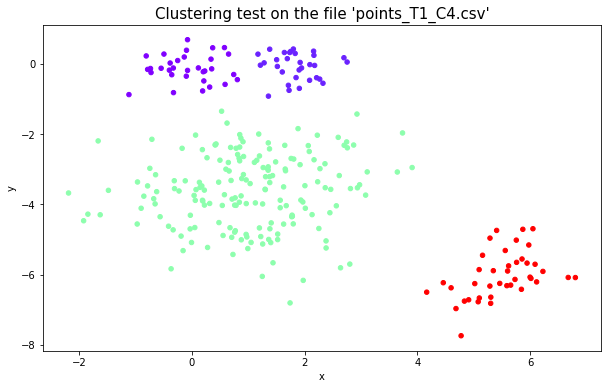

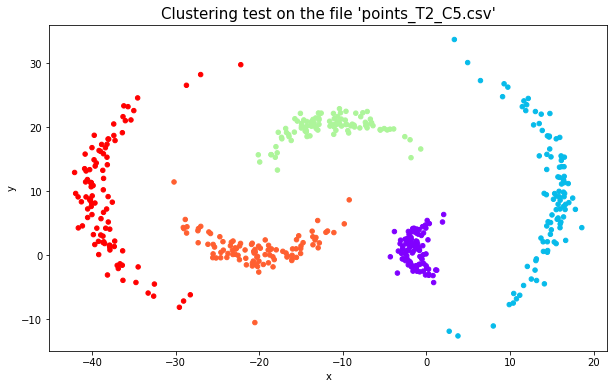

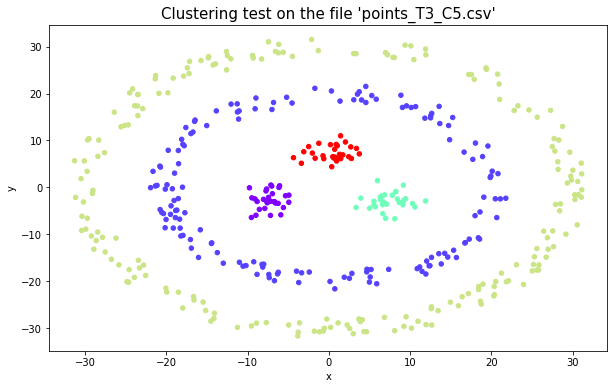

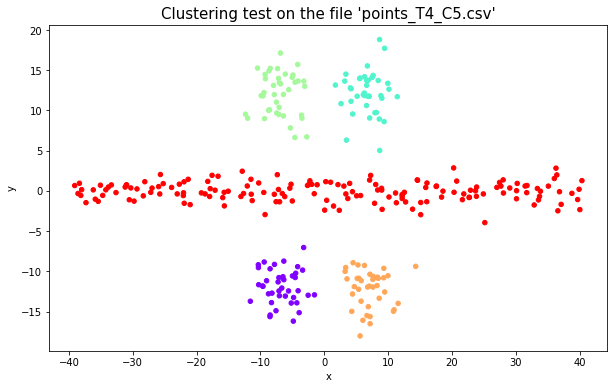

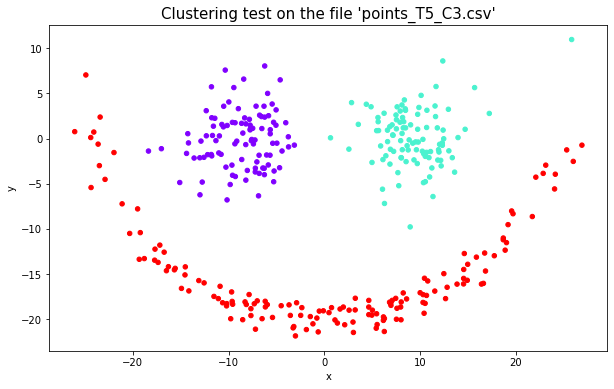

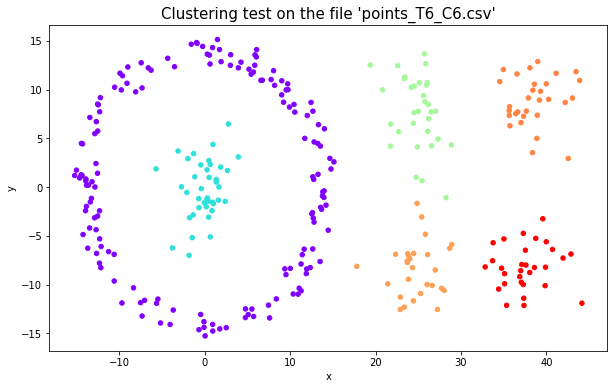

In [7]:
fileNames = ['points_T1_C4.csv', 'points_T2_C5.csv', 'points_T3_C5.csv', 'points_T4_C5.csv', 'points_T5_C3.csv', 'points_T6_C6.csv']
numsClusters = [4, 5, 5, 5, 3, 6]

for fileName, numClusters in zip(fileNames, numsClusters):
    reader = csv.reader(open(fileName), delimiter=",")
    pointsList = list(reader)
    points = np.array(pointsList).astype("float")

    Prw =  computeNormalizedAffinity(points)

    authorityshift_c = 0.95

    tags = authorityShiftPoint(points, Prw, authorityshift_c, numClusters)

    label=np.array(tags)
    pointsLabelled = np.zeros((points.shape[0], points.shape[1] + 1))
    pointsLabelled[:,0:2]=points
    pointsLabelled[:,2]=label
    
    dfLabelledPoints = pd.DataFrame(pointsLabelled, columns=['x', 'y','Cathegory'])
    
    # Print data clusters
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    dfLabelledPoints.plot.scatter('x', 'y',  c='Cathegory', cmap='rainbow', colorbar=False, ax = ax, subplots=True) 
    ax.set_title("Clustering test on the file '{}'".format(fileName), fontsize=15)
    plt.show()


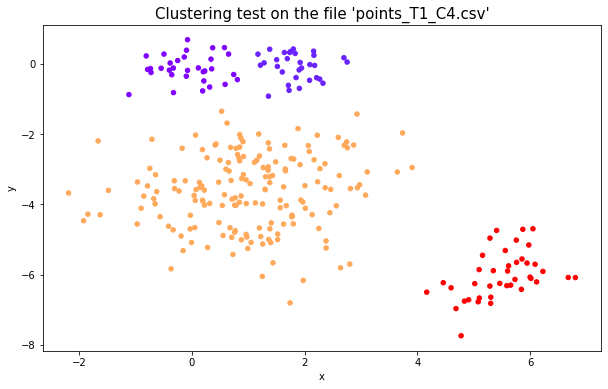

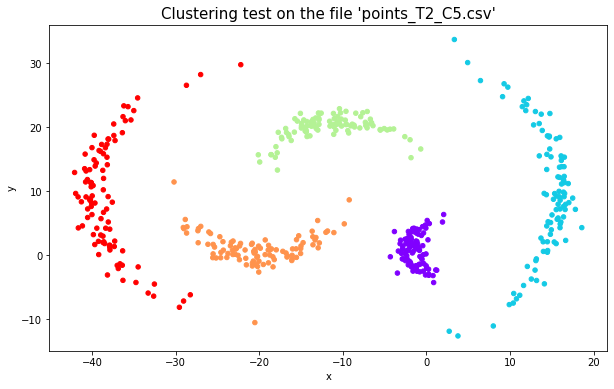

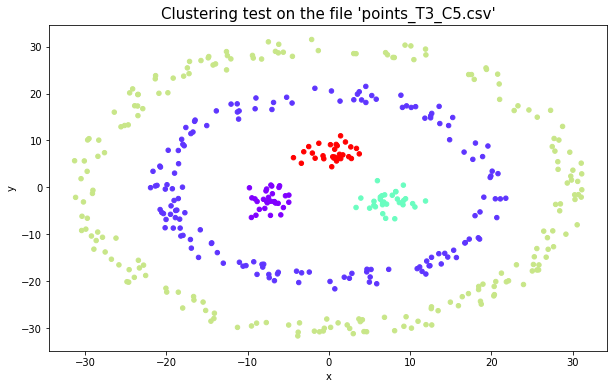

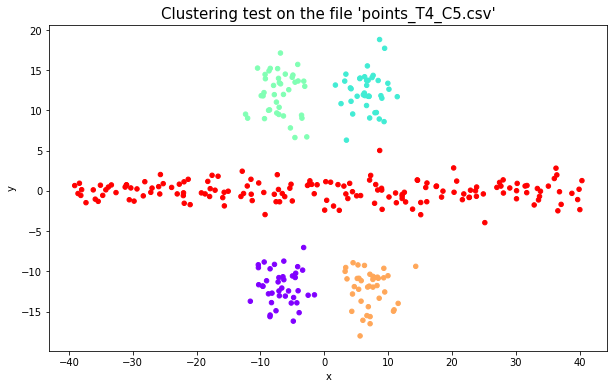

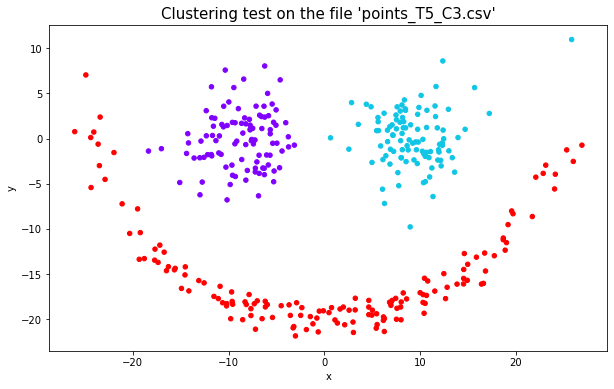

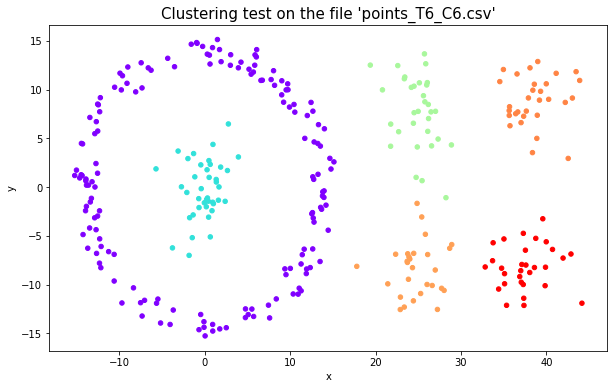

In [8]:
fileNames = ['points_T1_C4.csv', 'points_T2_C5.csv', 'points_T3_C5.csv', 'points_T4_C5.csv', 'points_T5_C3.csv', 'points_T6_C6.csv']
numsClusters = [4, 5, 5, 5, 3, 6]

for fileName, numClusters in zip(fileNames, numsClusters):
    reader = csv.reader(open(fileName), delimiter=",")
    pointsList = list(reader)
    points = np.array(pointsList).astype("float")

    Prw =  computeNormalizedAffinity(points)

    authorityshift_c = 0.95

    tags = authorityShiftPoint(points, Prw, authorityshift_c, numClusters, True)

    label=np.array(tags)
    pointsLabelled = np.zeros((points.shape[0], points.shape[1] + 1))
    pointsLabelled[:,0:2]=points
    pointsLabelled[:,2]=label

    dfLabelledPoints = pd.DataFrame(pointsLabelled, columns=['x', 'y','Cathegory'])
    
    # Print data clusters
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    dfLabelledPoints.plot.scatter('x', 'y',  c='Cathegory', cmap='rainbow', colorbar=False, ax = ax, subplots=True) 
    ax.set_title("Clustering test on the file '{}'".format(fileName), fontsize=15)
    plt.show()
    

# Confusion Table


The function computeConfusionTable computes the confusion table of the compued clusters with respect to the given true clusters (true labels)

In [9]:
################## computeConfusionTable ##################

def computeConfusionTable(labels, trueLabels, numClusters):
    # input: labels array of the computed labels
    # input: trueLabels array of the given true labels
    # input: numClusters number of clusters in the point cloud
    # output: matrix confusion matrix
    
    uniquelabels = np.unique(labels)
    uniquetrueLabels = np.unique(trueLabels)

    # dictionary for correspondence
    correspondences = {k : {key : 0 for key in uniquelabels} for k in uniquetrueLabels}
    
    # compute correspondence
    for i in range(labels.shape[0]):
        correspondences[trueLabels[i]][labels[i]] += 1
    
    # dictionaries to represent the map from trulabel to label and its inverse
    correspondenceslabel = {k : uniquelabels[0] for k in uniquetrueLabels}
    correspondenceslabelInverse = {k : uniquelabels[0] for k in uniquelabels}

    # compute dictionary map from truelabel to label
    for tl in correspondences:
        cnt = 0
        for l in correspondences[tl]:
            if correspondences[tl][l] > cnt:
                cnt = correspondences[tl][l]
                correspondenceslabel[tl] = l
    
    # compute inverse dictionary map from label to truelabel
    for tl in correspondenceslabel:
        correspondenceslabelInverse[correspondenceslabel[tl]] = tl

    # assign to each label the corresponding truelabel
    for i in range(labels.shape[0]):
        labels[i] = correspondenceslabelInverse[labels[i]]

    # dictionary for confusion matrix
    confusionmatrix = {k : {key : 0 for key in uniquetrueLabels} for k in uniquetrueLabels}
    for tl in correspondences:
        for l in correspondences[tl]:
            confusionmatrix[tl][correspondenceslabelInverse[l]] = correspondences[tl][l]
    
    # make confusion matrix
    matrix = np.zeros((len(uniquelabels), len(uniquelabels)))
    j=0
    for tl in correspondences:
        row = np.array((list(confusionmatrix[tl].values()))).reshape(1,numCluster)
        matrix[j][:] = row
        j+=1

    return matrix.astype("int")

Test of computeConfusionTable function, load point from 'Shape sets' datasets taken from http://cs.joensuu.fi/sipu/datasets/

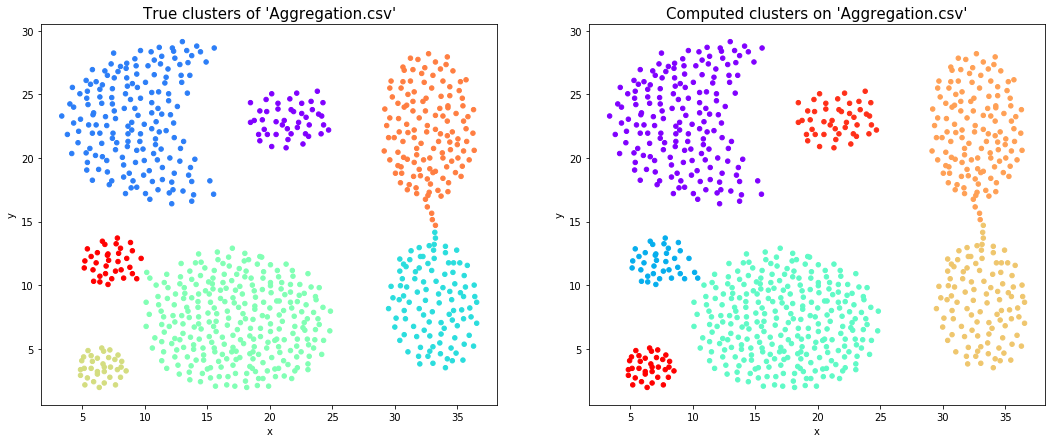


Confusion matrix of the file 'Aggregation.csv'
    0    1    2    3   4    5   6
0  45    0    0    0   0    0   0
1   0  170    0    0   0    0   0
2   0    0  102    0   0    0   0
3   0    0    0  271   0    0   2
4   0    0    0    0  34    0   0
5   0    0    1    0   0  129   0
6   0    0    0    0   0    0  34

Totalerror rate of the file Aggregation.csv : 0.004 




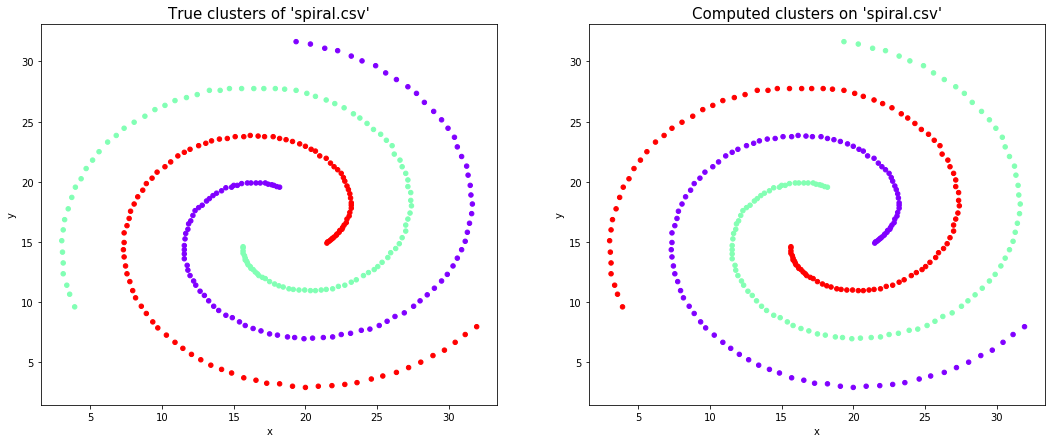


Confusion matrix of the file 'spiral.csv'
     0    1    2
0  101    0    0
1    0  105    0
2    0    0  106

Totalerror rate of the file spiral.csv : 0.000 




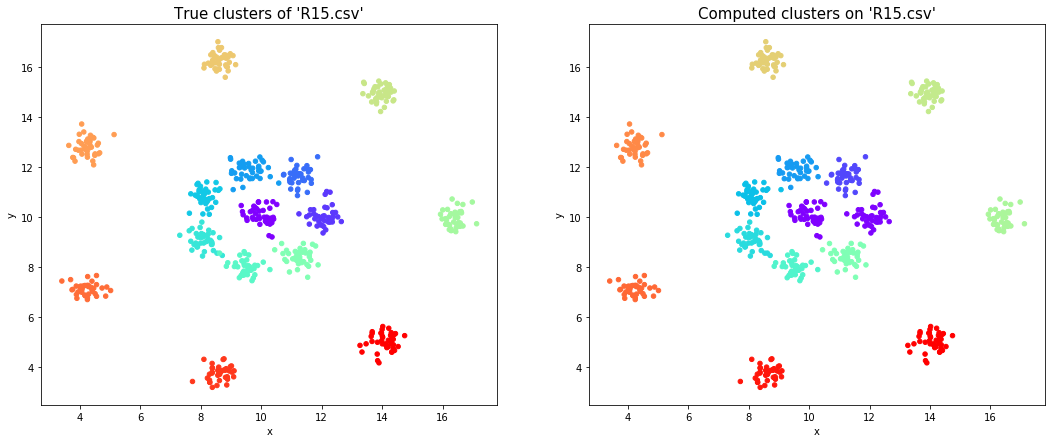


Confusion matrix of the file 'R15.csv'
     0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
0   40   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1    0  40   0   0   0   0   0   0   0   0   0   0   0   0   0
2    0   0  40   0   0   0   0   0   0   0   0   0   0   0   0
3    0   0   1  38   1   0   0   0   0   0   0   0   0   0   0
4    0   0   0   0  40   0   0   0   0   0   0   0   0   0   0
5    0   0   0   0   0  40   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   1  39   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0  40   0   0   0   0   0   0   0
8    0   0   0   0   0   0   0   0  40   0   0   0   0   0   0
9    0   0   0   0   0   0   0   0   0  40   0   0   0   0   0
10   0   0   0   0   0   0   0   0   0   0  40   0   0   0   0
11   0   0   0   0   0   0   0   0   0   0   0  40   0   0   0
12   0   0   0   0   0   0   0   0   0   0   0   0  40   0   0
13   0   0   0   0   0   0   0   0   0   0   0   0   0  40   0
14   0   0   0 

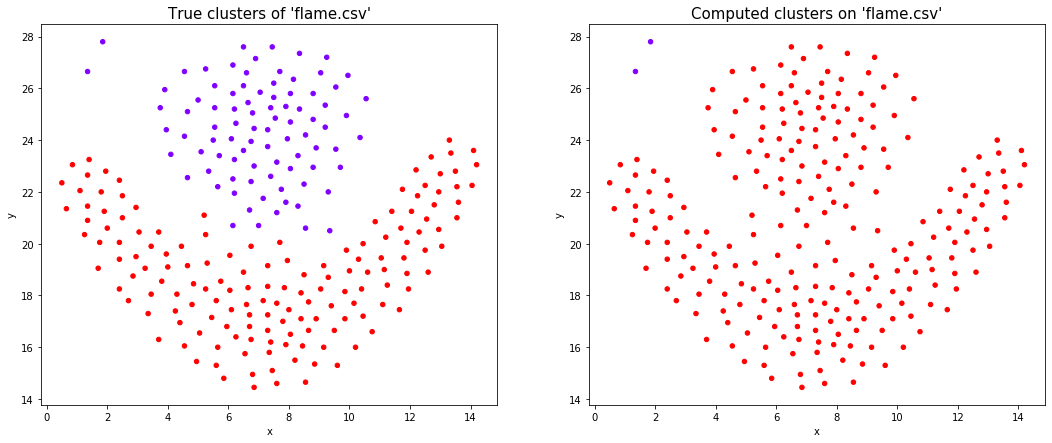


Confusion matrix of the file 'flame.csv'
   0    1
0  2   85
1  0  153

Totalerror rate of the file flame.csv : 0.354 




Average error rate (eith respect to the given files) : 0.091 




In [10]:
fileNames = ['Aggregation.csv', 'spiral.csv', 'R15.csv', 'flame.csv']
numsClusters = [7, 3, 15, 2]

# array with the error rates on all the data performed for each file
errorRates = []

for fileName, numCluster in zip(fileNames, numsClusters):
    reader = csv.reader(open(fileName), delimiter=",")
    pointsList = list(reader)
    points = np.array(pointsList).astype("float")
    
    # Extracting the given true-labels from the data
    trueLabels = points[:,2]
    
    Prw = computeNormalizedAffinity(points[:,0:2])

    authorityshift_c = 0.95

    tags = authorityShiftPoint(points, Prw, authorityshift_c, numCluster)
    
    labels = np.array(tags)
    pointsLabelled = np.zeros((points.shape[0], points.shape[1]))
    pointsLabelled[:,0:2] = points[:,0:2]
    
    # scatter the true-clusters and the computed-cluster for visual comparison
    pointsLabelled[:,2] = labels
    dfLabelledPoints_True = pd.DataFrame(points, columns=['x', 'y','Cathegory'])
    dfLabelledPoints_Comp = pd.DataFrame(pointsLabelled, columns=['x', 'y','Cathegory'])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
    dfLabelledPoints_True.plot.scatter('x', 'y',  c='Cathegory', cmap='rainbow', colorbar=False, ax = axes[0], subplots=True)
    axes[0].set_title("True clusters of '{}'".format(fileName), fontsize=15)
    dfLabelledPoints_Comp.plot.scatter('x', 'y',  c='Cathegory', cmap='rainbow', colorbar=False, ax = axes[1], subplots=True)
    axes[1].set_title("Computed clusters on '{}'".format(fileName), fontsize=15)
    plt.show()
    
    # compute confusion table
    confusionMatrix = computeConfusionTable(labels, trueLabels, numCluster)   
    
    # print confusion matrix
    print("\nConfusion matrix of the file '{}'".format(fileName))
    print(pd.DataFrame(confusionMatrix))
    
    # error rate for all the data
    totalNumCorrectLabels = np.sum(np.diag(confusionMatrix))
    errRate = 1 - (totalNumCorrectLabels / points.shape[0])
    
    # add the computed errorRate to 'errorRates' average error computation
    errorRates.append(errRate)
    
    # print error rate
    print("\nTotalerror rate of the file %s : %2.3f \n\n"% (fileName, errRate))
    
    
# printing average error rate
avgErrRate = sum(errorRates) / len(fileNames)
print("\n\nAverage error rate (with respect to the given files) : %2.3f \n\n"% (avgErrRate))